In [1]:
%reload_ext autoreload
%autoreload 2

import cv2

import os
import sys
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from collections import defaultdict

from matplotlib.path import Path
%matplotlib inline

from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

from FeatureExtractor import *

In [280]:
features = np.load(patch_dir+'/test_features.npy')

In [326]:
# label1 = 'Gr'
label1 = '12N'

In [327]:
coef = np.load('classifiers/%s_non%s_linear_svm_coef.npy' % (label1, label1))
intercept = np.load('classifiers/%s_non%s_linear_svm_intercept.npy' % (label1, label1))
selected_feature_indices = np.load('classifiers/%s_non%s_linear_svm_selectedFeatureIndices.npy' % (label1, label1))

In [328]:
scores = np.dot(features[:, selected_feature_indices], np.squeeze(coef)) + intercept
Y = np.sign(scores)

In [322]:
# cv2.polylines(viz2, [np.int32(adjusted_vertices[sec])], True, (255,0,255), 5)
# cv2.polylines(viz2, [np.int32( vertices_Gr - (xmin, ymin))], True, (0,255,255), 5)

In [329]:
viz2 = img_as_ubyte(viz.copy())

thresh = -1

for (x, y), sc in zip(np.array(patch_locations) - (xmin, ymin), scores):
    if sc > thresh:
        c = (0,255,0)
    else:
        c = (255,0,0)
#     cv2.rectangle(viz2, (x-half_size, y-half_size), (x+half_size, y+half_size), c, 5)
    cv2.circle(viz2, (x,y), 10, c, 5)

In [303]:
patch_locations[0]
for i in range(100):
    if patch_locations[i][0] == patch_locations[0][0]:
        print i

0
47
94


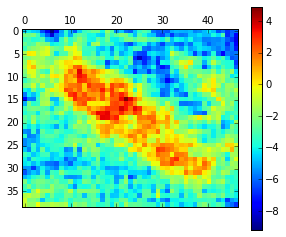

In [330]:
plt.matshow(scores.reshape((1833/47, 47)));
plt.colorbar();

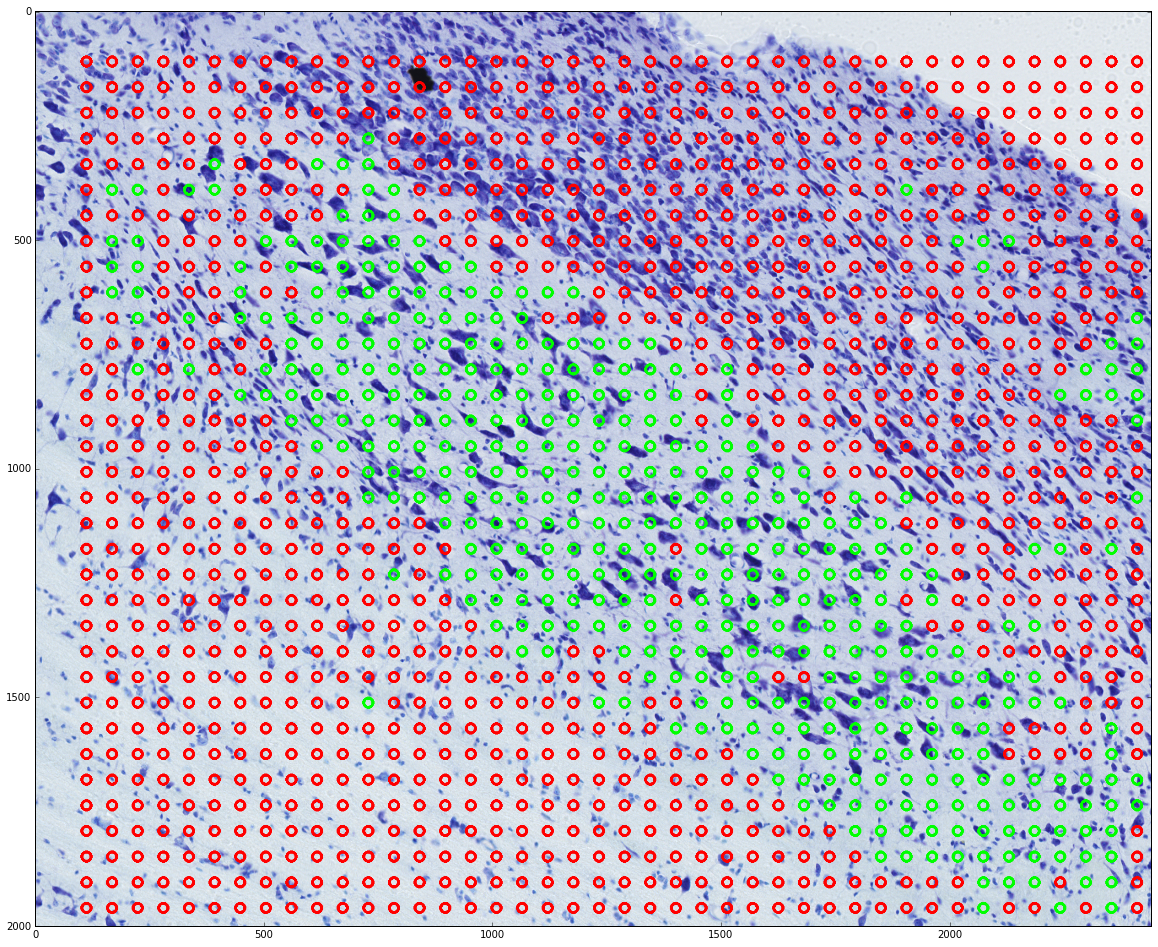

In [332]:
plt.figure(figsize=(20,20));
plt.imshow(viz2);

In [80]:
plt.imsave('../public/figures/labelmap_score%.2f.jpg'%thresh, viz2)

In [ ]:
display(viz2)